# Clustering on term frequencies

In [110]:
%matplotlib inline

## Load count matrices

In [111]:
import pandas as pd

df = pd.concat(
    (
        pd.read_csv('../features/metadata/tf_descriptions.csv', index_col=0),
        pd.read_csv('../features/metadata/tf_keywords.csv', index_col=0),
        pd.read_csv('../features/metadata/tf_titles.csv', index_col=0),
    ),
    axis=1
)
df = df.groupby(df.columns, axis=1).sum() # Drop duplicate columns
df['tag'] = pd.read_csv('../features/tags.csv', index_col=0)['tag_name']

y = df['tag']
X = df.drop('tag', axis=1)

## TF-IDF transform

In [112]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)

tfidf_matrix = pd.DataFrame(
    data=transformer.fit_transform(X).todense(),
    index=X.index,
    columns=X.columns
)

## K-means clustering

In [113]:
from sklearn import cluster

n_clusters = 8
km = cluster.KMeans(n_clusters=n_clusters)

%time km.fit(tfidf_matrix)

clusters = pd.Series(km.labels_.tolist(), X.index)

CPU times: user 4.84 s, sys: 232 ms, total: 5.07 s
Wall time: 4.62 s


### Top 10 words per cluster

In [146]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_matrix.columns

for i in range(num_clusters):
    print('Cluster {}'.format(i))
    print('----------')
    print(', '.join([terms[j] for j in order_centroids[i, :10]]))
    print('\n')

Cluster 0
----------
dvd, bodybuilding, muscle, receive, posing, nabba, figure, workout, olympia, ifbb


Cluster 1
----------
york, city, new, paparazzo, autograph, fan, nyc, tmz, fashion, marc


Cluster 2
----------
grittv, lauraflanders, grit, f, word, commentary, 2008, july, flanders, august


Cluster 3
----------
news, ointment, comedy, funny, fake, tatham, clinton, politics, bayside, daily


Cluster 4
----------
tarot, psychic, reading, free, nick, magick, witchcraft, newage, occult, spiritual


Cluster 5
----------
video, study, health, new, music, u, recipe, disease, ha, help


Cluster 6
----------
snack, lunch, political, politicallunch, politics, mccain, tuesday, obama, clinton, look


Cluster 7
----------
commercial, domain, classic, public, advertisement, archiveorg, license, spot, creative, common




### Top 10 words per tag

In [145]:
for tag, group in df.groupby('tag'):
    print(tag)
    print('--------------------')
    top_words = group.drop('tag', axis=1).sum(axis=0).nlargest(10)
    print(', '.join(top_words.keys().tolist()))
    print('\n')

autos_and_vehicles
--------------------
bumper2bumpertv, car, gregmorrison, insight, got, look, new, 2009, acura, altima


food_and_drink
--------------------
recipe, food, chef, like, tea, drink, visit, episode, cook, wwwlegourmettv


health
--------------------
health, study, new, disease, jamareport, help, risk, woman, patient, cancer


movies_and_television
--------------------
commercial, public, classic, domain, common, advertisement, archiveorg, creative, license, spot


music_and_entertainment
--------------------
new, york, city, paparazzo, music, fan, nyc, autograph, tmz, interview


politics
--------------------
grittv, obama, lauraflanders, politics, political, u, 2008, news, grit, lunch


religion
--------------------
tarot, psychic, reading, bayside, nick, spiritual, free, story, god, lady


sports
--------------------
dvd, muscle, bodybuilding, receive, posing, nabba, figure, power, like, new




## Multidimensional scaling

In [124]:
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity

distances = 1 - cosine_similarity(tfidf_matrix)
mds = manifold.MDS(n_components=2, dissimilarity='precomputed')
positions = mds.fit_transform(distances)  

points = pd.DataFrame({
    'x': positions[:, 0],
    'y': positions[:, 1],
    'tag': df['tag']
})

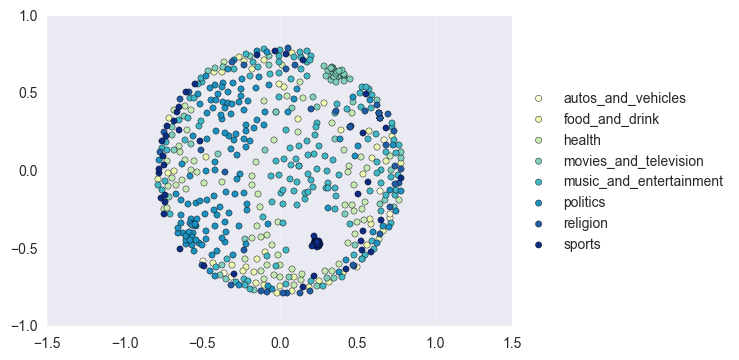

In [135]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
colors = [
    '#ffffd9',
    '#edf8b1',
    '#c7e9b4',
    '#7fcdbb',
    '#41b6c4',
    '#1d91c0',
    '#225ea8',
    '#0c2c84'
] # Generated with ColorBrewer

for (tag, group), color in zip(points.groupby('tag'), colors):
    ax.scatter(group['x'], group['y'], c=color, label=tag)

ax.axis('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Hierarchical document clustering

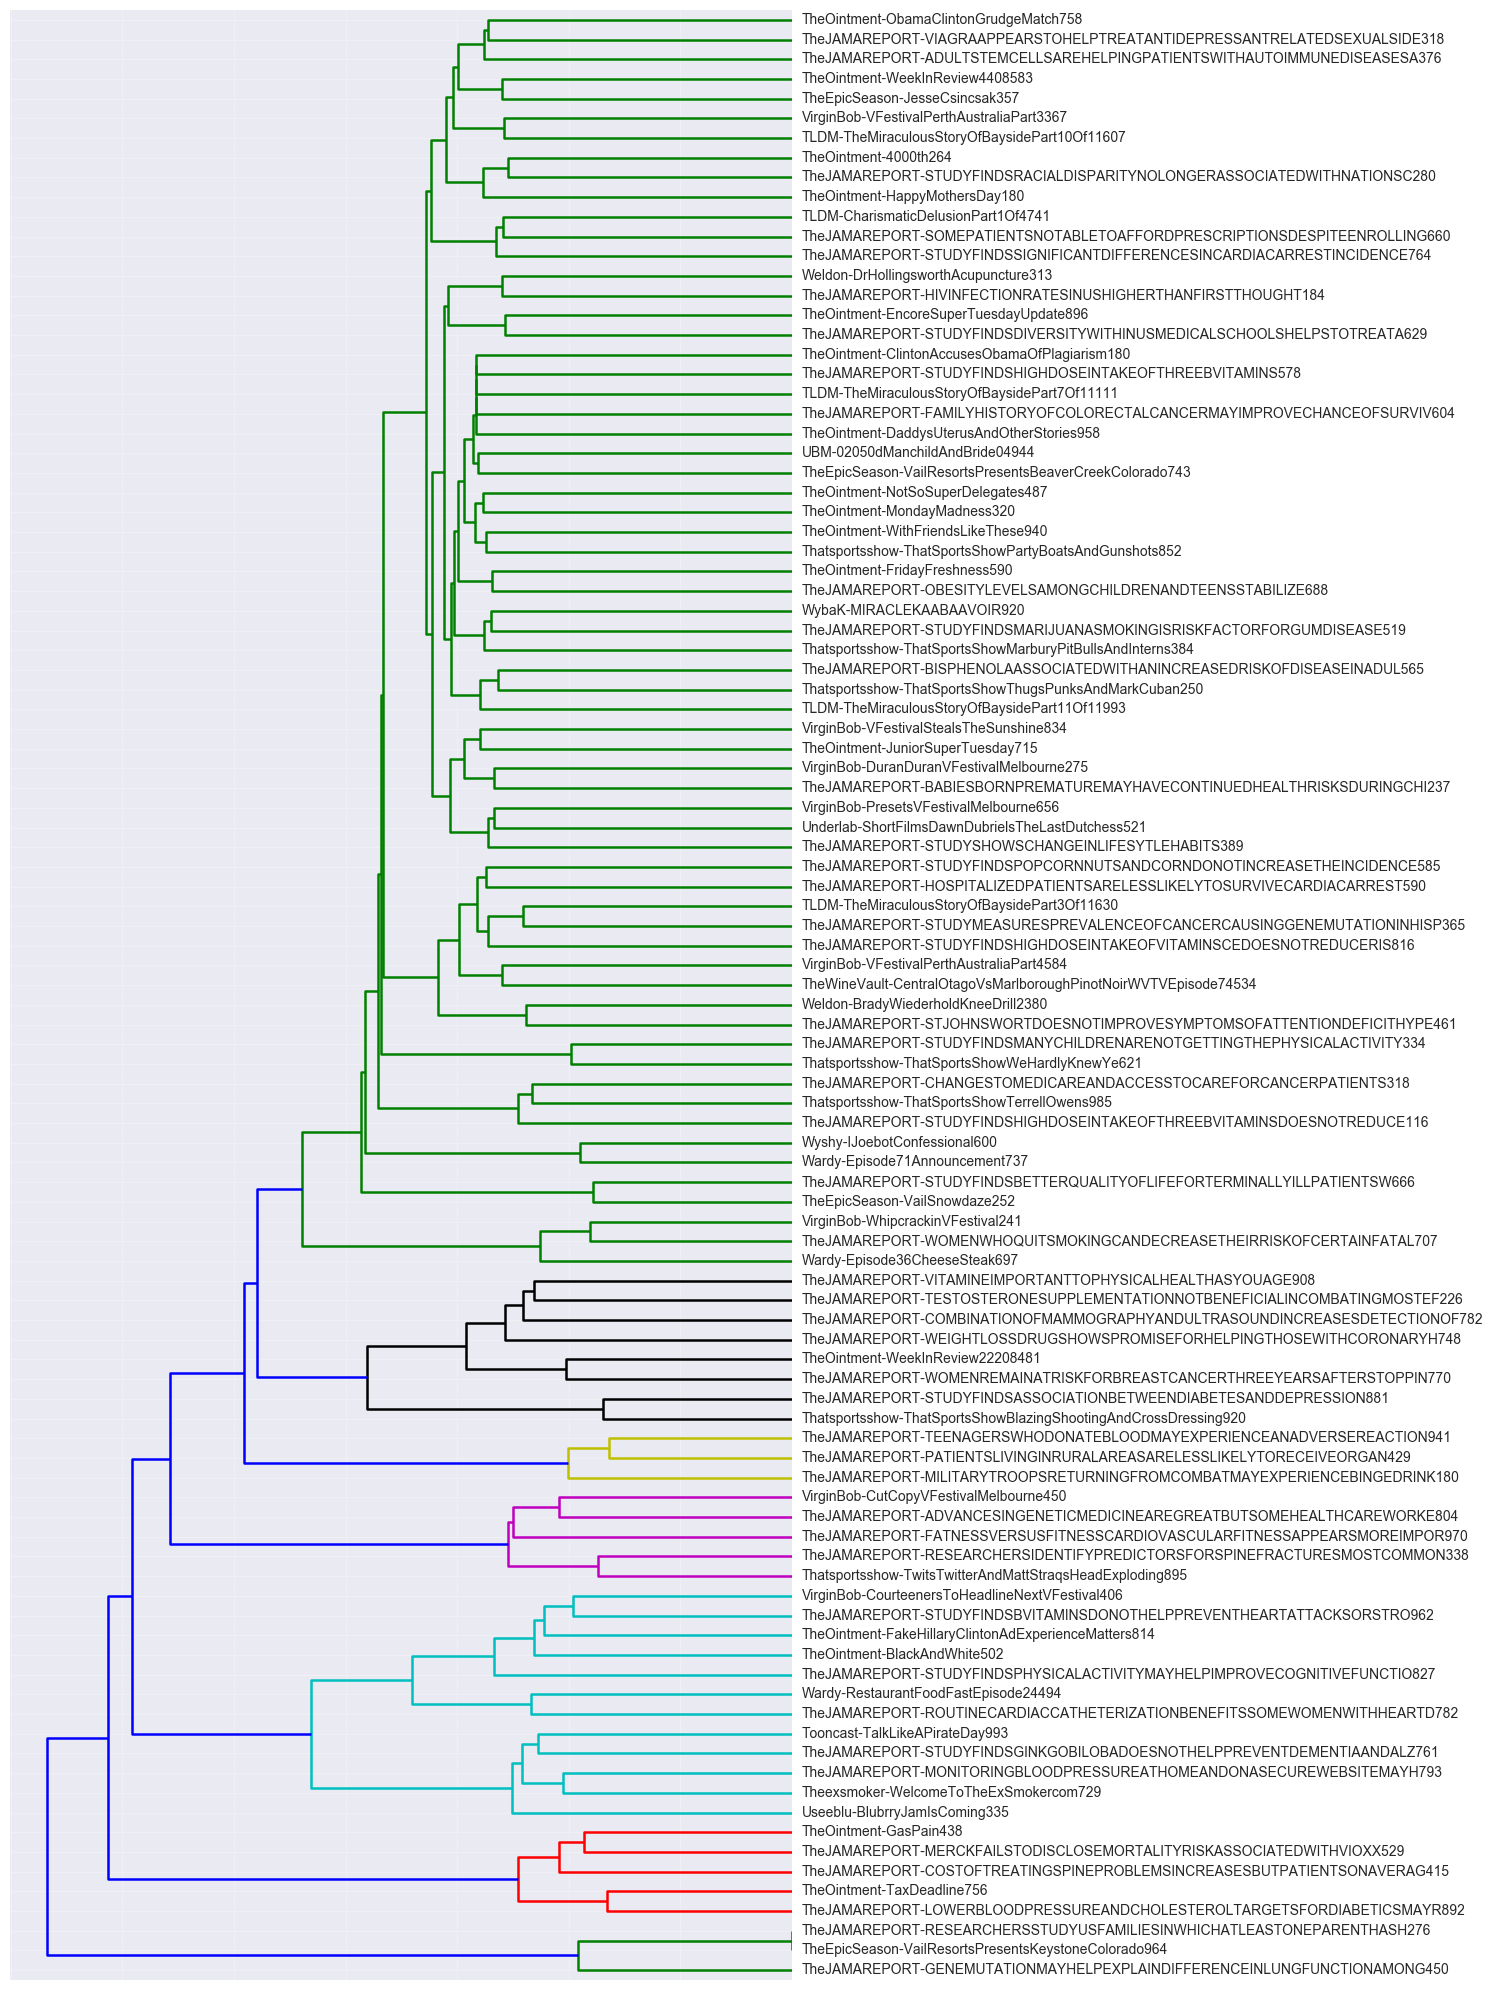

In [105]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix.sample(100))

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation='right', labels=X.index)

plt.tick_params(
    axis='x',      
    which='both',     
    bottom='off',     
    top='off',  
    labelbottom='off'
)

plt.tight_layout()

## Latent Dirichlet Allocation

In [147]:
from sklearn import decomposition

n_topics = 8

lda = decomposition.LatentDirichletAllocation(
    n_topics=n_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50
)

%time lda.fit(tfidf_matrix)

CPU times: user 914 ms, sys: 4.32 ms, total: 918 ms
Wall time: 917 ms


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=8, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [148]:
terms = tfidf_matrix.columns

for i, topic in enumerate(lda.components_):
    print('Topic {}:'.format(i))
    print('---------')
    print(', '.join([terms[j] for j in reversed(topic.argsort()[-10:])]))
    print('\n')

Topic 0:
---------
news, obama, tax, clinton, tuesday, politics, political, tea, funny, ointment


Topic 1:
---------
commercial, public, domain, classic, creative, spot, license, common, archiveorg, advertisement


Topic 2:
---------
clubhousegas, fca, vfestival, video, 2009, cancer, family, golf, anglicantv, shrimp


Topic 3:
---------
dvd, bodybuilding, muscle, receive, bayside, movie, new, like, weight, tarot


Topic 4:
---------
study, film, snack, miracle, charismatic, patient, cardiac, arrest, dubriels, food


Topic 5:
---------
grittv, lauraflanders, grit, 2008, word, f, july, commentary, vfestival, flanders


Topic 6:
---------
city, york, new, health, paparazzo, week, comedy, news, fake, politics


Topic 7:
---------
political, politics, lunch, obama, clinton, snack, commentary, man, news, michigan


